In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.tri as tri
%matplotlib notebook
import numpy as np

import moleculetools as mt

In [2]:
asn10 = mt.read_xyz("asn10.xyz")

In [3]:
system = mt.Structure(elements=asn10[0], coords=asn10[1])

Molecule instantiated!



In [4]:
system.find_center()
system.center

array([2.958099  , 0.953471  , 0.05866667])

In [5]:
system.find_axis()

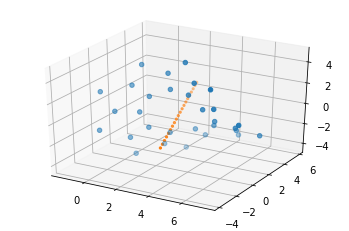

In [6]:
n_points = 20
axis_points = np.reshape(np.linspace(-5, 5, n_points), (n_points, 1))
points = np.matmul(axis_points, np.reshape(system.main_axis, (1, 3))) + system.center

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(system.coords[:,0], system.coords[:,1], system.coords[:,2], marker='o')
ax.scatter(points[:,0], points[:,1], points[:,2], marker='.')
#d_coords = system.coords + system.main_axis*1
#ax.scatter(d_coords[:,0], d_coords[:,1], d_coords[:,2], marker='o')

ValueError: num must be 1 <= num <= 4, not 0

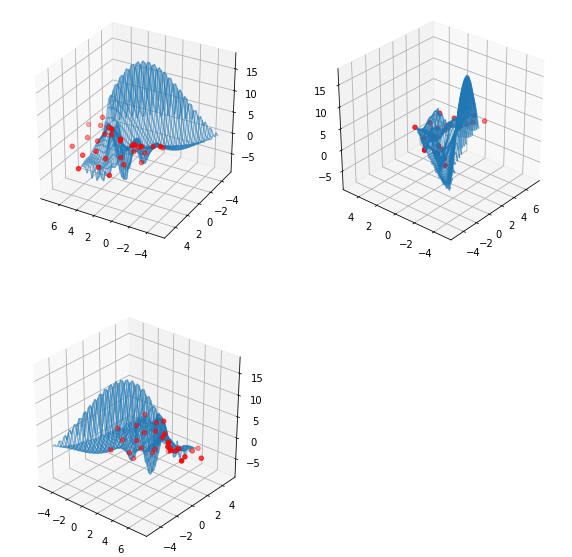

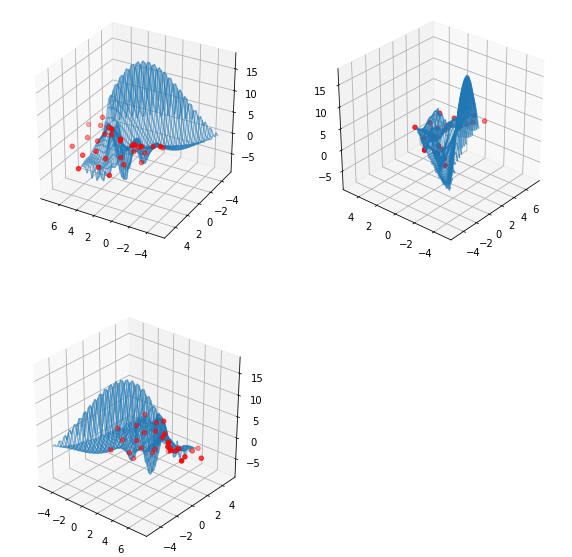

<Figure size 720x720 with 0 Axes>

In [22]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from scipy.interpolate import griddata as gd

top = np.array([
[33.44, 87.93, 105.88],
[8.81, 84.07, 103.11],
[15.62, 34.83, 105.98],
[40.16, 38.71, 108.13],
[61.45, 67.07, 108.12],
[58.81, 91.44, 107.72],
[36.97, 63.29, 107.14],
[64.71, 42.38, 109.07],
[89.11, 46.49, 109.93],
[67.24, 18.32, 109.99],
[65.90, 31.93, 109.51],
[76.55, 44.51, 109.91]])
top = system.coords

bot = np.array([
[15.59, 35.07, 12.88],
[38.57, 37.17, 13.33],
[61.10, 67.15, 17.31],
[58.97, 92.05, 19.09],
[36.98, 63.24, 16.51],
[64.45, 42.66, 20.01],
[89.18, 46.85, 27.71],
[66.87, 18.48, 14.24],
[65.90, 31.93, 21.0],
[76.55, 44.51, 22.0]
])
bot = system.coords


# 'nearest', 'linear', 'cubic'
interpolationmethod = 'cubic'
p = 2
extrapolation_interval = 30


def main():
    extrapolation_spots = get_plane(0, 200, 0, 200, extrapolation_interval)
    nearest_analysis(extrapolation_spots)


def nearest_analysis(extrapolation_spots):
    top_extra = extrapolation(top, extrapolation_spots, method='nearest')
    bot_extra = extrapolation(bot, extrapolation_spots, method='nearest')
    gridx_top, gridy_top, gridz_top = interpolation(top_extra)
    plot(top, gridx_top, gridy_top, gridz_top, method='snaps',
            title='_top_nearest')
    gridx_bot, gridy_bot, gridz_bot = interpolation(bot_extra)
    plot(bot, gridx_bot, gridy_bot, gridz_bot, method='snaps',
            title='_bot_nearest')

    plot(np.concatenate((top, bot)), [gridx_top, gridx_bot],
              [gridy_top, gridy_bot],
              [gridz_top, gridz_bot], method='snaps', title='_both_nearest',
            both=True)


def nearest_neighbor_interpolation(data, x, y, p=0.5):
    """
    Nearest Neighbor Weighted Interpolation
    http://paulbourke.net/miscellaneous/interpolation/
    http://en.wikipedia.org/wiki/Inverse_distance_weighting

    :param data: numpy.ndarray
        [[float, float, float], ...]
    :param p: float=0.5
        importance of distant samples
    :return: interpolated data
    """
    n = len(data)
    vals = np.zeros((n, 2), dtype=np.float64)
    distance = lambda x1, x2, y1, y2: (x2 - x1)**2 + (y2 - y1)**2
    for i in range(n):
        vals[i, 0] = data[i, 2] / (distance(data[i, 0], x, data[i, 1], y))**p
        vals[i, 1] = 1          / (distance(data[i, 0], x, data[i, 1], y))**p
    z = np.sum(vals[:, 0]) / np.sum(vals[:, 1])
    return z


def get_plane(xl, xu, yl, yu, i):
    xx = np.arange(xl, xu, i)
    yy = np.arange(yl, yu, i)
    extrapolation_spots = np.zeros((len(xx) * len(yy), 2))
    count = 0
    for i in xx:
        for j in yy:
            extrapolation_spots[count, 0] = i
            extrapolation_spots[count, 1] = j
            count += 1
    return extrapolation_spots


def extrapolation(data, extrapolation_spots, method='nearest'):
    if method == 'kriging':
        pass

    if method == 'nearest':
        new_points = np.zeros((len(extrapolation_spots), 3))
        new_points[:, 0] = extrapolation_spots[:, 0]
        new_points[:, 1] = extrapolation_spots[:, 1]
        for i in range(len(extrapolation_spots)):
            new_points[i, 2] = nearest_neighbor_interpolation(data,
                                    extrapolation_spots[i, 0],
                                    extrapolation_spots[i, 1], p=p)
        combined = np.concatenate((data, new_points))
        return combined


def interpolation(data):
    gridx, gridy = np.mgrid[0:150:50j, 0:150:50j]
    gridz = gd(data[:, :2],data[:, 2], (gridx, gridy),
                method=interpolationmethod)
    return gridx, gridy, gridz


def plot(data, gridx, gridy, gridz, method='rotate', title='nearest', both=False):
    def update(i):
        ax.view_init(azim=i)
        return ax,

    if method == 'rotate':
        fig = plt.figure()
        ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection='3d')

        ax.plot_wireframe(gridx, gridy, gridz, alpha=0.5)
        ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='red')

        animation.FuncAnimation(fig, update, np.arange(360 * 5), interval=1)
        plt.show()

    elif method== 'snaps':
        fig = plt.figure(figsize=(10, 10))
        angles = [45, 120, 220, 310]

        if both:
            for i in range(4):
                ax = fig.add_subplot(2, 2, i, projection='3d')
                ax.plot_wireframe(gridx[0], gridy[0], gridz[0], alpha=0.5)
                ax.plot_wireframe(gridx[1], gridy[1], gridz[1], alpha=0.5)
                ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='red')
                ax.view_init(azim=angles[i])
        else:
            for i in range(1, 4):
                ax = fig.add_subplot(2, 2, i, projection='3d')
                ax.plot_wireframe(gridx, gridy, gridz, alpha=0.5)
                ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='red')
                ax.view_init(azim=angles[i])

        plt.savefig('snaps_{}.png'.format(title))

    elif method == 'contour':
        fig = plt.figure()
        ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection='3d')

        ax.plot_wireframe(gridx, gridy, gridz, alpha=0.5)
        ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='red')

        ax.contourf(gridx, gridy, gridz, zdir='z', offset=np.min(data[:, 2]), cmap=cm.coolwarm)
        ax.contourf(gridx, gridy, gridz, zdir='x', offset=0, cmap=cm.coolwarm)
        ax.contourf(gridx, gridy, gridz, zdir='y', offset=0, cmap=cm.coolwarm)
        ax.view_init(azim=45)
        plt.show()


if __name__ == '__main__':
    sys.exit(main())